In [ ]:
! nvidia-smi

Fri Jul 28 07:43:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/nanekja/pytorch_utils

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 166 (delta 97), reused 116 (delta 49), pack-reused 0
Receiving objects: 100% (166/166), 24.45 KiB | 6.11 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [ ]:
from __future__ import print_function

import torch
import torch.optim as optim
import torchvision
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau

!pip install albumentations
!pip install torchsummary
!pip install tqdm
!pip install torchinfo torch_lr_finder

import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import torch_lr_finder as lr

sys.path.append('./pytorch_utils/')
import main
import utils
import transform
#import custom_resnet
import train1
import test1
import dataloader
import albumentation
from gradcam import GradCAM,visualize_cam

sys.path.append('./pytorch_utils/models/')
import resnet_18


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:13<00:00, 12785533.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = utils.get_device()
print(device)

cuda


In [ ]:
mean, std = utils.get_mean_and_std()

Files already downloaded and verified
 - Dataset Numpy Shape: (50000, 32, 32, 3)
 - Min: [0. 0. 0.]
 - Max: [1. 1. 1.]
 - Mean: [0.49139968 0.48215841 0.44653091]
 - Std: [0.24703223 0.24348513 0.26158784]
 - Var: [15.56135559 15.11767693 17.44919073]


Files already downloaded and verified


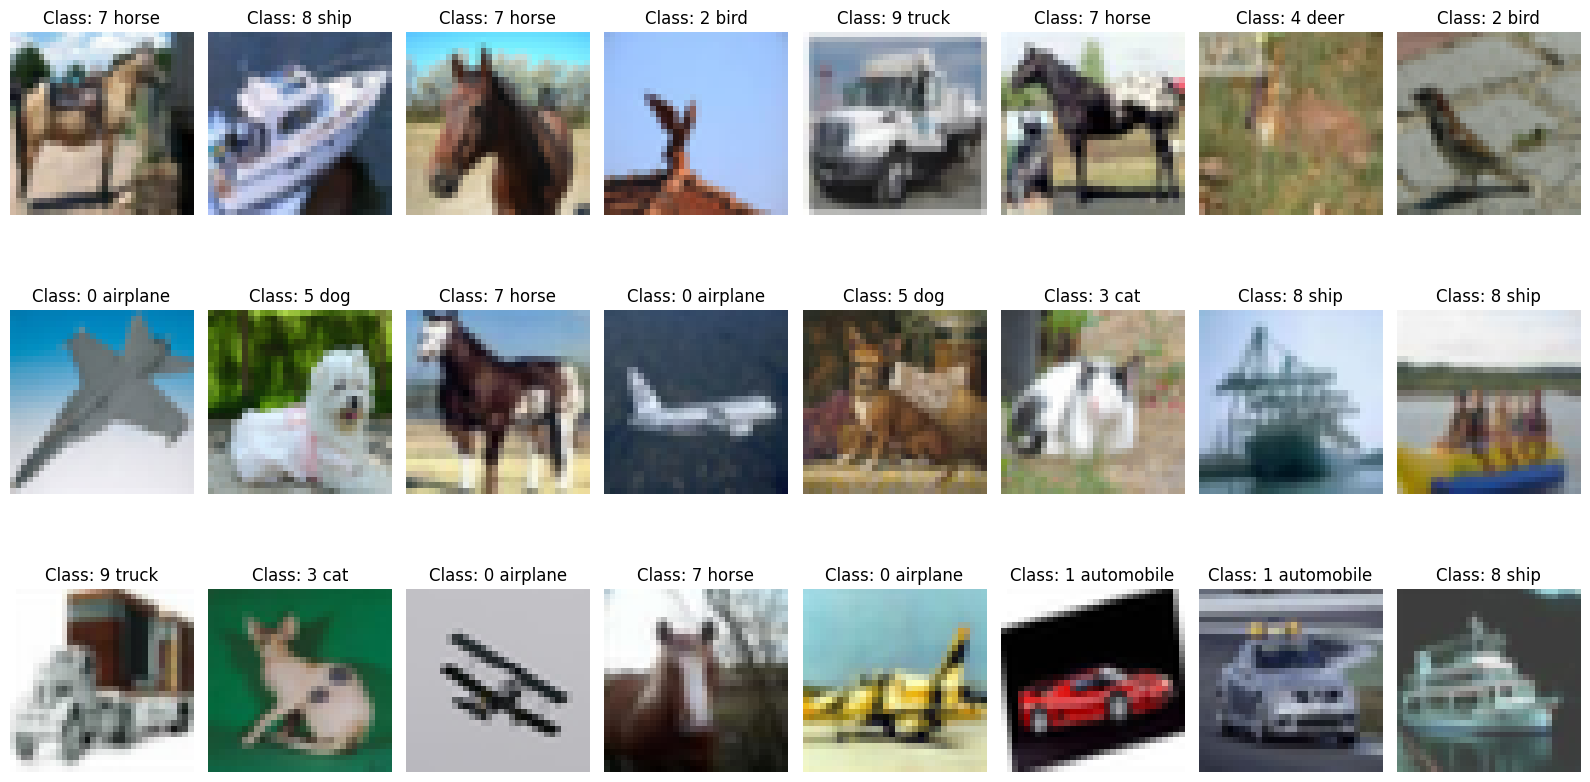

In [ ]:
exp = torchvision.datasets.CIFAR10('./data', train=True, download=True)
utils.plot_data(exp,3,8)

torch.Size([32, 3, 32, 32])
torch.Size([32])


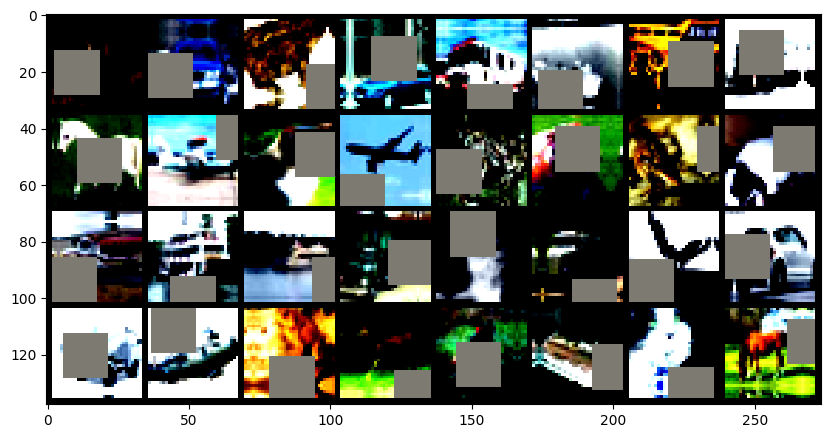

In [ ]:
dataiter = iter(transform.train_loader)

images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# show images
utils.imshow(torchvision.utils.make_grid(images))

In [ ]:
from models import resnet_18

model = resnet_18.ResNet18().to(device)

!pip install torchscan --no-deps
from torchscan import summary

summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

____________________________________________________________________________
Layer       Type           Output Shape         Param #      Receptive field
resnet      ResNet         (-1, 10)             0            1              
├─conv1     Conv2d         (-1, 64, 32, 32)     1,728        3              
├─bn1       BatchNorm2d    (-1, 64, 32, 32)     257          3              
├─layer1    Sequential     (-1, 64, 32, 32)     148,484      11             
├─layer2    Sequential     (-1, 128, 16, 16)    526,853      33             
├─layer3    Sequential     (-1, 256, 8, 8)      2,102,277    121            
├─layer4    Sequential     (-1, 512, 4, 4)      8,398,853    473            
├─linear    Linear         (-1, 10)             5,130        473            
Trainable params: 11,173,962
Non-trainable params: 0
Total params: 11,173,962
----------------------------------------------------------------------------
Model size (params + buffers): 42.66 Mb
Framework & CUDA overhead: 1074.19 

/usr/local/lib/python3.10/dist-packages/torchscan/modules/flops.py:67: UserWarning: Module type not supported: Sequential
  warnings.warn(f"Module type not supported: {module.__class__.__name__}")
/usr/local/lib/python3.10/dist-packages/torchscan/modules/macs.py:50: UserWarning: Module type not supported: Sequential
  warnings.warn(f"Module type not supported: {module.__class__.__name__}")
/usr/local/lib/python3.10/dist-packages/torchscan/modules/memory.py:59: UserWarning: Module type not supported: Sequential
  warnings.warn(f"Module type not supported: {module.__class__.__name__}")
/usr/local/lib/python3.10/dist-packages/torchscan/modules/receptive.py:55: UserWarning: Module type not supported: Sequential
  warnings.warn(f"Module type not supported: {module.__class__.__name__}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/500 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.72E-02


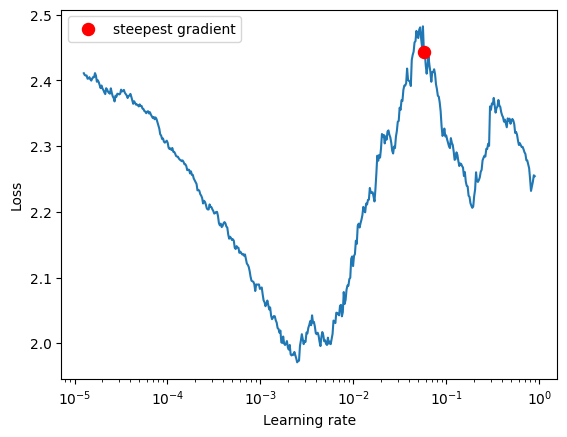

Selected learning rate : 0.002481930289186254


In [ ]:
#lrmax=0.01
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
#optimizer = optim.Adam(model.parameters(), lr=lrmax)

optimizer = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0005)

ideal_lr=utils.find_lr(model, optimizer, criterion, transform.train_loader)


In [ ]:
#Train again with one cycle policy now
#EPOCHS = 24
#max_epoch=5

#scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
#scheduler = OneCycleLR(optimizer,max_lr= 0.2, steps_per_epoch=steps_per_epoch,epochs=epochs, pct_start=pct_start,div_factor=10,final_div_factor=10,verbose=False)
#scheduler = OneCycleLR(optimizer=optimizer, max_lr=lrmax, epochs=EPOCHS, steps_per_epoch=len(transform.train_loader), pct_start=max_epoch/EPOCHS, div_factor=10)
optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9,weight_decay=0.0001, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, patience = 2)

In [ ]:
EPOCHS = 20

net, history = main.fit_model(model, device, transform.train_loader, transform.test_loader, optimizer, criterion, scheduler, EPOCHS)

EPOCH: 1 (LR: 0.002481930289186254)


Batch_id=1562 Loss=1.50832 Accuracy=44.97: 100%|██████████| 1563/1563 [01:00<00:00, 25.64it/s]



Test set: Average loss: -3.8548, Accuracy: 6121/10000 (61.21%)

EPOCH: 2 (LR: 0.002481930289186254)


Batch_id=1562 Loss=1.13438 Accuracy=59.49: 100%|██████████| 1563/1563 [01:00<00:00, 25.89it/s]



Test set: Average loss: -5.6332, Accuracy: 6868/10000 (68.68%)

EPOCH: 3 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.96172 Accuracy=66.00: 100%|██████████| 1563/1563 [01:01<00:00, 25.39it/s]



Test set: Average loss: -6.2881, Accuracy: 7489/10000 (74.89%)

EPOCH: 4 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.86171 Accuracy=69.76: 100%|██████████| 1563/1563 [01:01<00:00, 25.39it/s]



Test set: Average loss: -6.9460, Accuracy: 8019/10000 (80.19%)

EPOCH: 5 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.77837 Accuracy=72.75: 100%|██████████| 1563/1563 [01:01<00:00, 25.42it/s]



Test set: Average loss: -7.5511, Accuracy: 7868/10000 (78.68%)

EPOCH: 6 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.72324 Accuracy=74.91: 100%|██████████| 1563/1563 [01:01<00:00, 25.52it/s]



Test set: Average loss: -7.9049, Accuracy: 8177/10000 (81.77%)

EPOCH: 7 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.67622 Accuracy=76.63: 100%|██████████| 1563/1563 [01:02<00:00, 25.13it/s]



Test set: Average loss: -7.9747, Accuracy: 8328/10000 (83.28%)

EPOCH: 8 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.63858 Accuracy=77.67: 100%|██████████| 1563/1563 [01:02<00:00, 24.97it/s]



Test set: Average loss: -8.8052, Accuracy: 8300/10000 (83.00%)

EPOCH: 9 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.59518 Accuracy=79.23: 100%|██████████| 1563/1563 [01:01<00:00, 25.56it/s]



Test set: Average loss: -9.3419, Accuracy: 8575/10000 (85.75%)

EPOCH: 10 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.57180 Accuracy=80.25: 100%|██████████| 1563/1563 [01:02<00:00, 25.01it/s]



Test set: Average loss: -9.6172, Accuracy: 8538/10000 (85.38%)

EPOCH: 11 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.54720 Accuracy=80.89: 100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]



Test set: Average loss: -8.8570, Accuracy: 8458/10000 (84.58%)

EPOCH: 12 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.52771 Accuracy=81.59: 100%|██████████| 1563/1563 [01:03<00:00, 24.69it/s]



Test set: Average loss: -10.0275, Accuracy: 8649/10000 (86.49%)

EPOCH: 13 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.50176 Accuracy=82.81: 100%|██████████| 1563/1563 [01:03<00:00, 24.68it/s]



Test set: Average loss: -10.5015, Accuracy: 8801/10000 (88.01%)

EPOCH: 14 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.48661 Accuracy=83.13: 100%|██████████| 1563/1563 [01:03<00:00, 24.65it/s]



Test set: Average loss: -10.3745, Accuracy: 8875/10000 (88.75%)

EPOCH: 15 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.46824 Accuracy=83.72: 100%|██████████| 1563/1563 [01:03<00:00, 24.63it/s]



Test set: Average loss: -10.5530, Accuracy: 8867/10000 (88.67%)

EPOCH: 16 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.44958 Accuracy=84.29: 100%|██████████| 1563/1563 [01:03<00:00, 24.64it/s]



Test set: Average loss: -10.7235, Accuracy: 8763/10000 (87.63%)

EPOCH: 17 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.43540 Accuracy=84.73: 100%|██████████| 1563/1563 [01:03<00:00, 24.70it/s]



Test set: Average loss: -10.9559, Accuracy: 8902/10000 (89.02%)

EPOCH: 18 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.42497 Accuracy=85.16: 100%|██████████| 1563/1563 [01:03<00:00, 24.59it/s]



Test set: Average loss: -10.8105, Accuracy: 8825/10000 (88.25%)

EPOCH: 19 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.41413 Accuracy=85.46: 100%|██████████| 1563/1563 [01:03<00:00, 24.67it/s]



Test set: Average loss: -11.2041, Accuracy: 8884/10000 (88.84%)

EPOCH: 20 (LR: 0.002481930289186254)


Batch_id=1562 Loss=0.40442 Accuracy=85.91: 100%|██████████| 1563/1563 [01:03<00:00, 24.67it/s]



Test set: Average loss: -11.6628, Accuracy: 8959/10000 (89.59%)



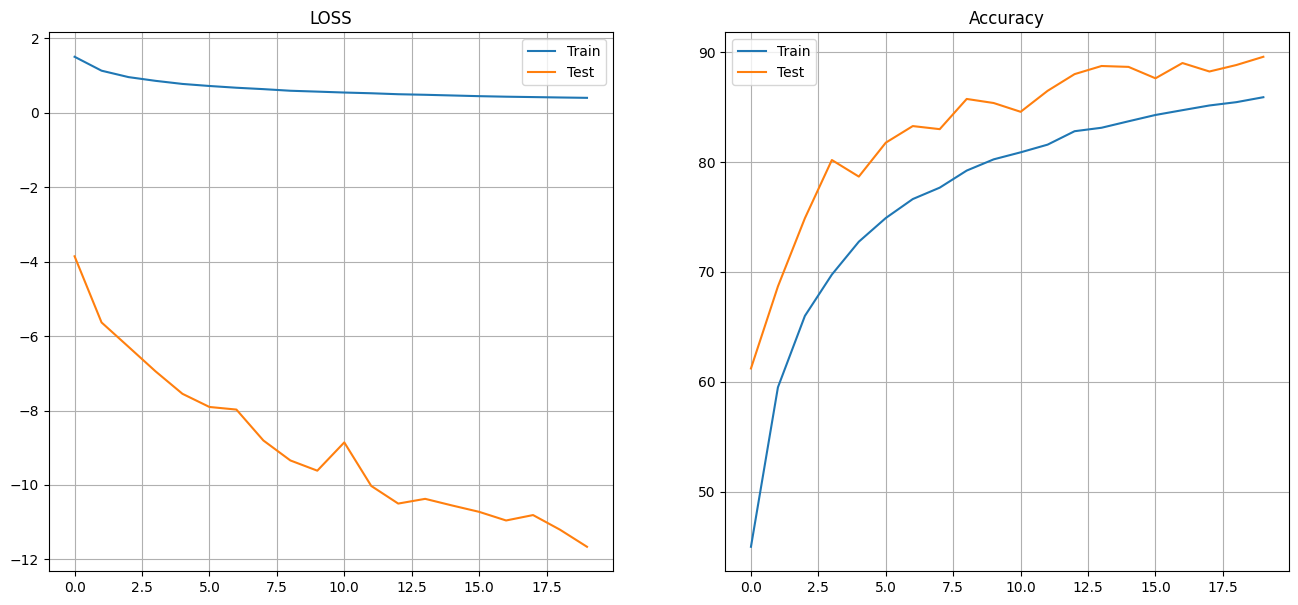

In [ ]:
utils.result_graphs(history)

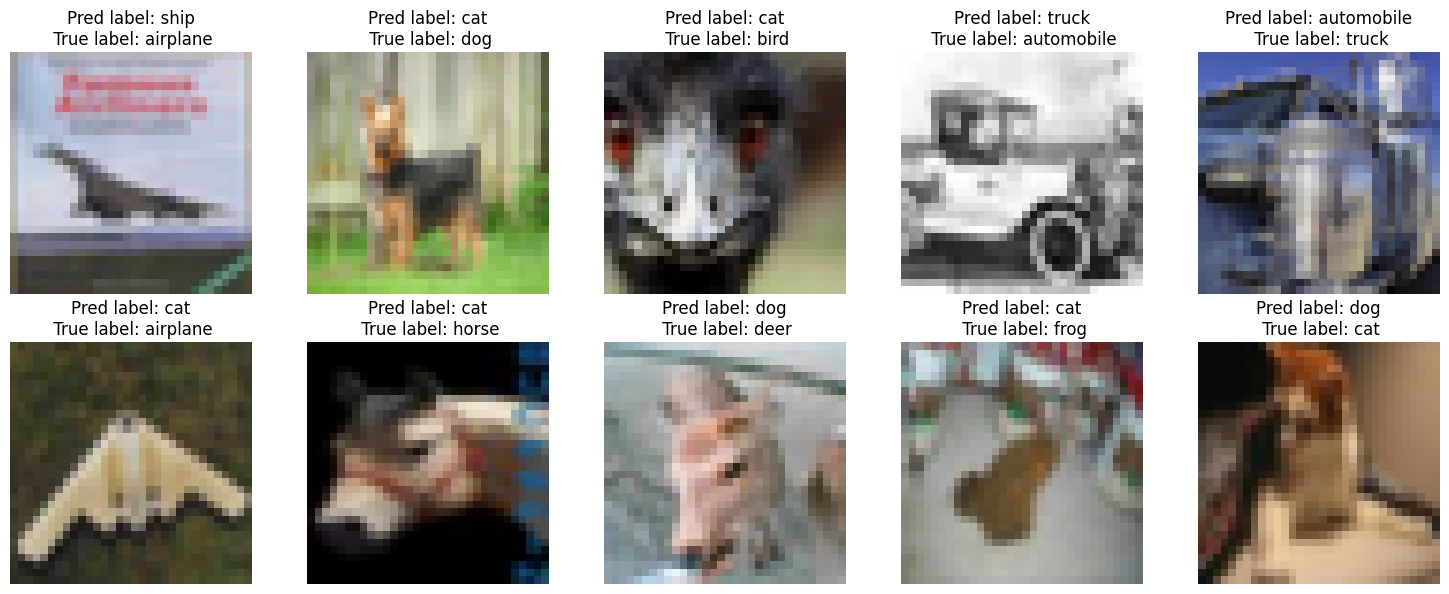

In [ ]:
misclf = utils.plot_misclassified(net, transform.test_loader, transform.testset.classes, device, mean, std, return_misclf=True)

In [ ]:
total_images = 10
gradcam_misclassified_images = utils.get_misclassified_images(model, device, transform.test_loader, transform.testset.classes, total_images)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


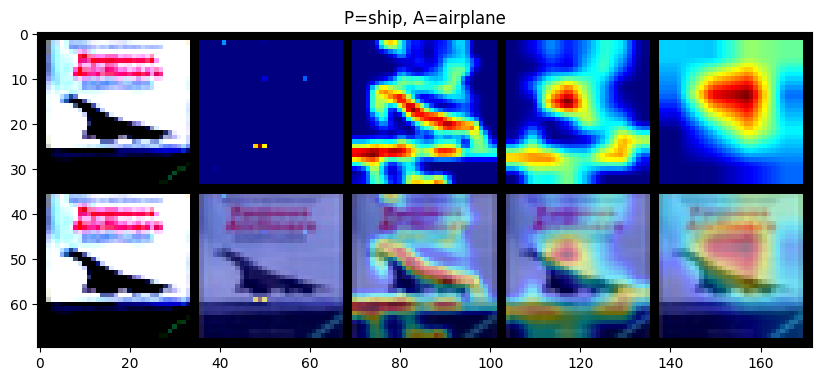

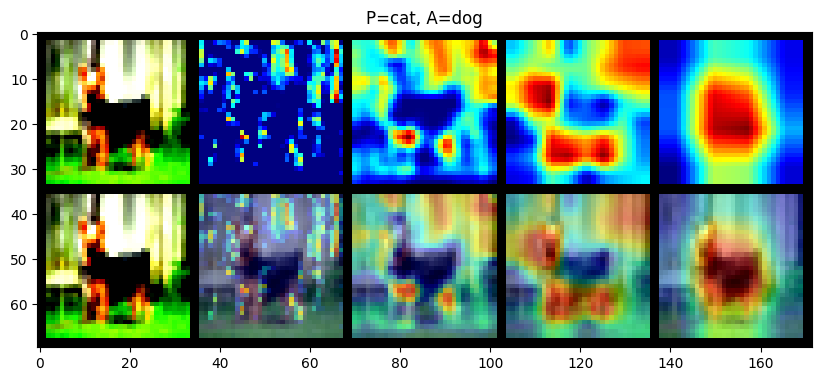

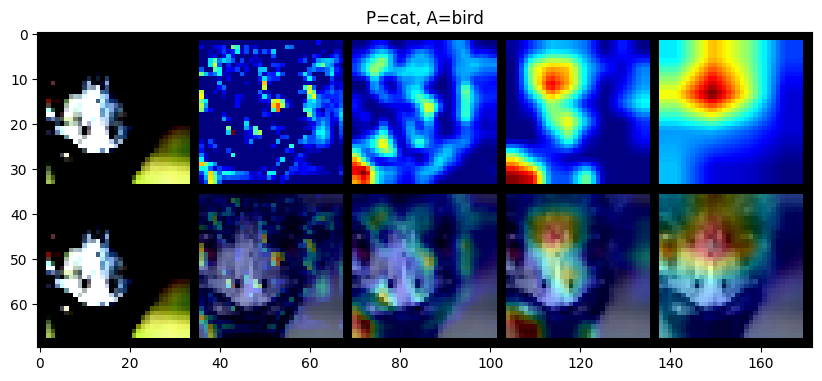

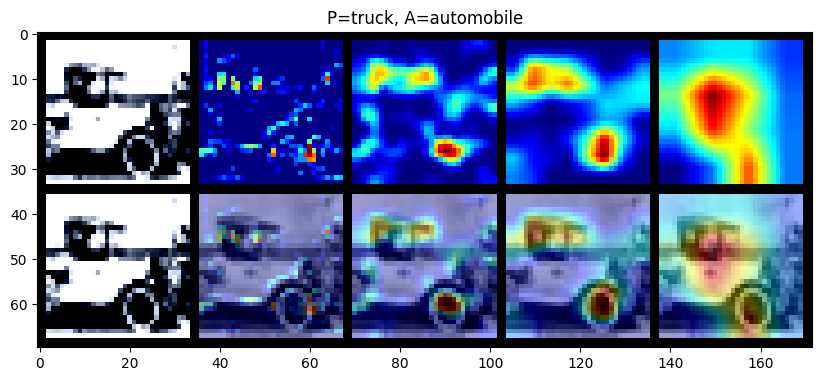

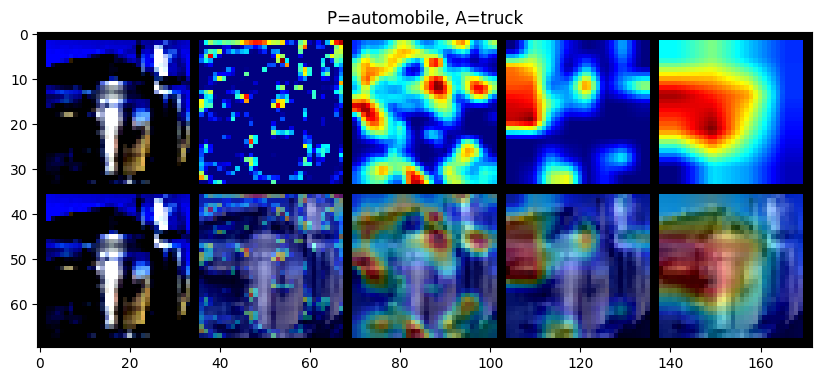

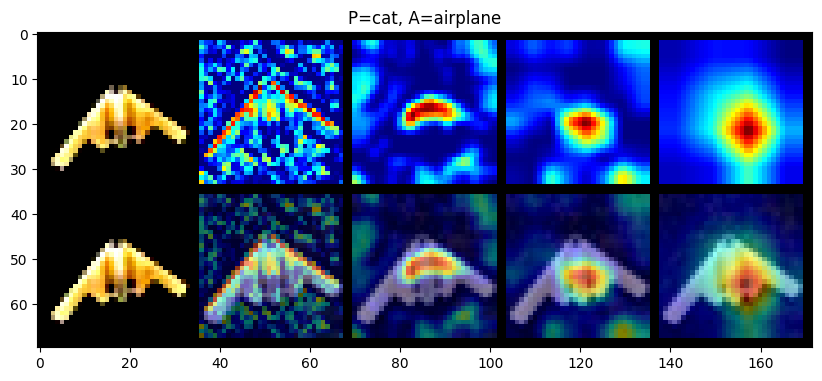

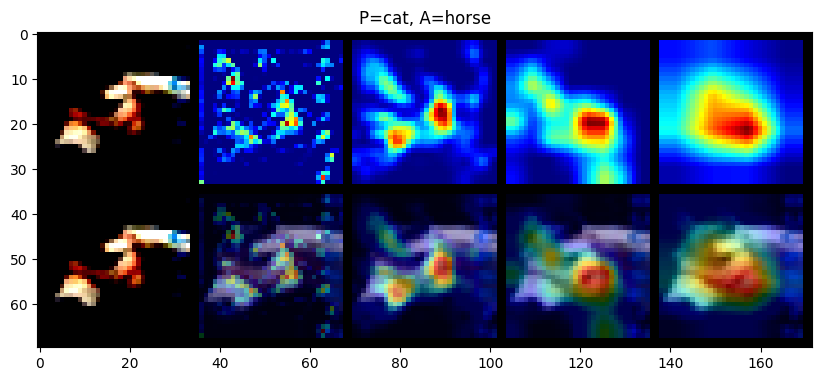

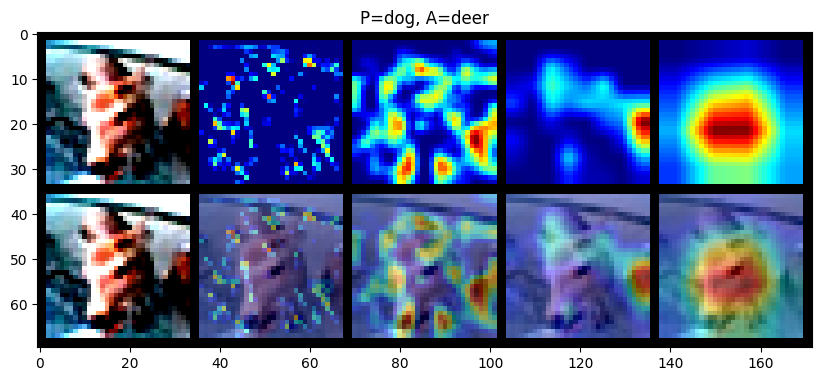

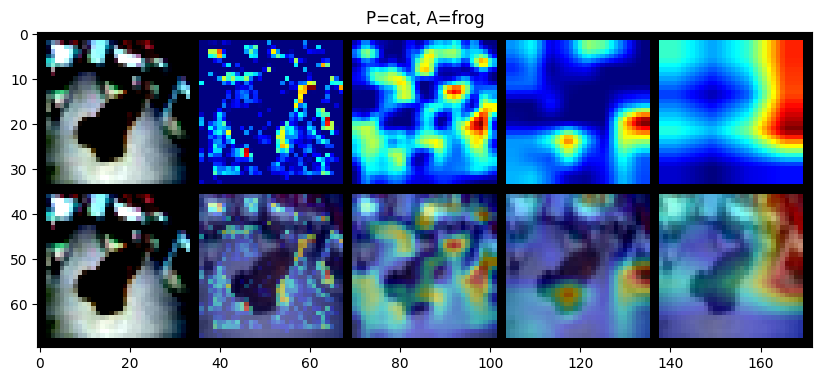

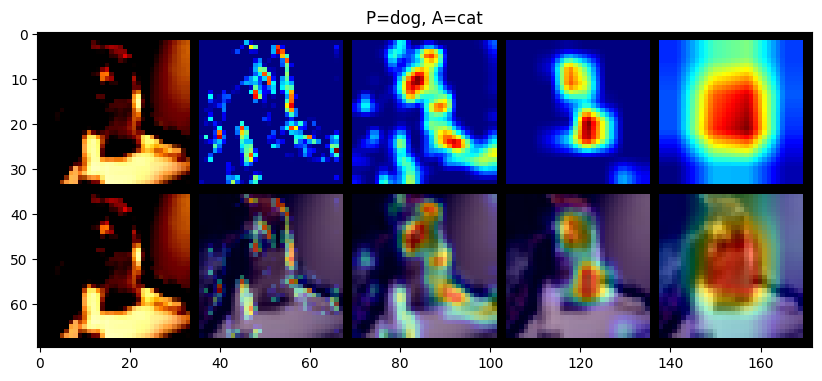

In [ ]:
import copy
from torchvision.utils import make_grid, save_image
for i,k in enumerate(gradcam_misclassified_images):
  images1 = [gradcam_misclassified_images[i][0].cpu()]
  images2 =  [gradcam_misclassified_images[i][0].cpu()]
  b = copy.deepcopy(model.to(device))
  #b = copy.deepcopy(model)
  output = model(gradcam_misclassified_images[i][0].unsqueeze(0))
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    # mask, _= g(gradcam_misclassified_images[i][0].unsqueeze(0))
    # heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0])
    mask, _= g(gradcam_misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5)
  # imshow(grid_image,c = classes[int(predicted)])
  utils.imshow(grid_image,c = "P={}, A={}".format(str(transform.testset.classes[gradcam_misclassified_images[i][1].data.cpu().numpy()]),str(transform.testset.classes[gradcam_misclassified_images[i][2].data.cpu().numpy()])))